In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, GRU
from keras.layers import Dropout

Using TensorFlow backend.


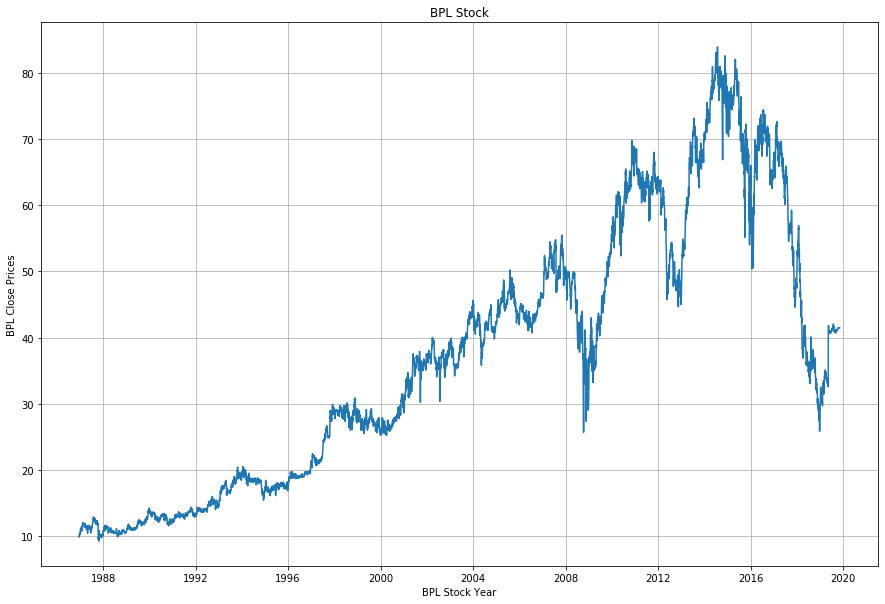

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('/Users/saurabhwadhawane/stockdata1_BPL.csv', sep=',', parse_dates=['date'], index_col='date',date_parser=dateparse)

plt.figure(figsize=(15,10))
plt.grid(True)
plt.title("BPL Stock")
plt.xlabel('BPL Stock Year')
plt.ylabel('BPL Close Prices')
plt.plot(data['close']);       

In [3]:
data.shape

(8292, 7)

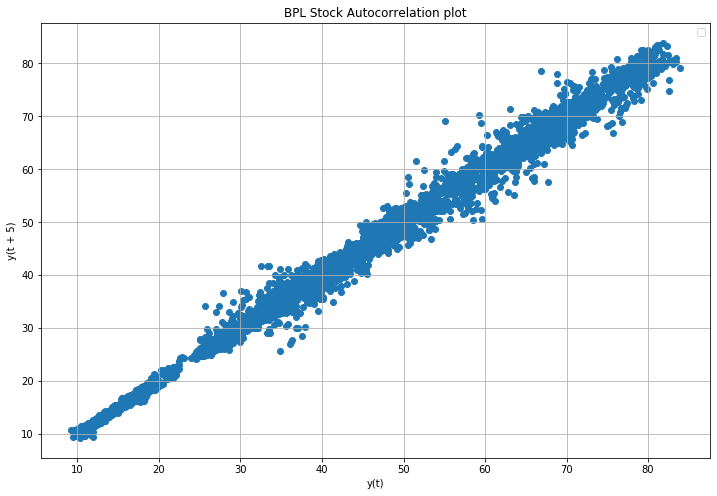

In [4]:
#Autocorrelation plot
plt.figure(figsize=(12,8))
lag_plot(data['close'], lag=5)
plt.title('BPL Stock Autocorrelation plot')
plt.grid(True)
plt.legend();

<Figure size 1152x576 with 0 Axes>

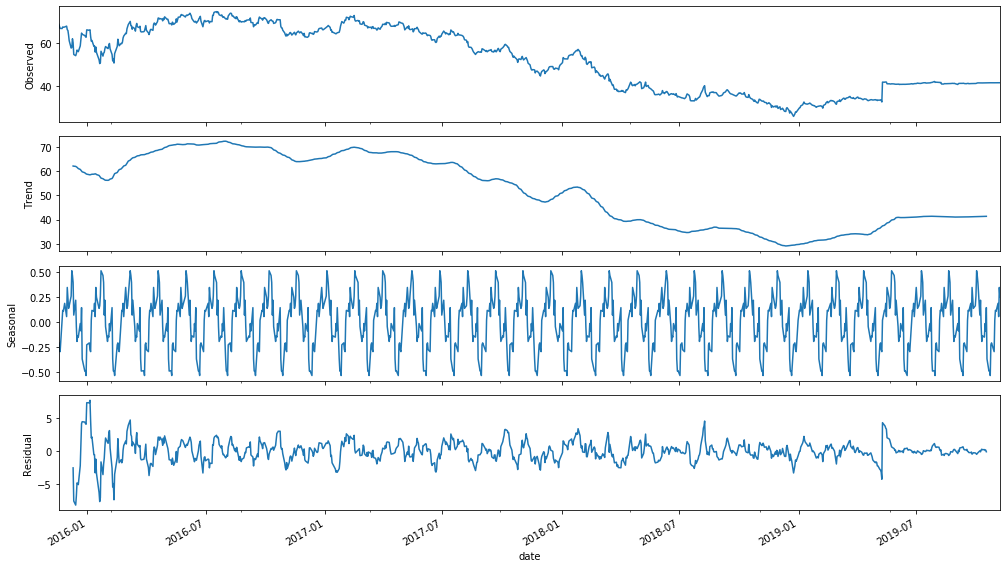

In [5]:
rcParams['figure.figsize'] = 14, 8
data_arima = data['close']
result = seasonal_decompose(data_arima[-1000:], model='additive', freq=30)
plt.figure(figsize=(16,8))
fig = result.plot()
plt.show()

In [6]:
values = DataFrame(data['close'].values)
dataframe = concat([values.shift(1),values.shift(5),values.shift(10),values.shift(30), values], axis=1)
dataframe.columns = ['t', 't+1', 't+5', 't+10', 't+30']
result = dataframe.corr()
print(result)

             t       t+1       t+5      t+10      t+30
t     1.000000  0.997892  0.995831  0.989869  0.999503
t+1   0.997892  1.000000  0.997437  0.991042  0.997437
t+5   0.995831  0.997437  1.000000  0.992471  0.995435
t+10  0.989869  0.991042  0.992471  1.000000  0.989588
t+30  0.999503  0.997437  0.995435  0.989588  1.000000


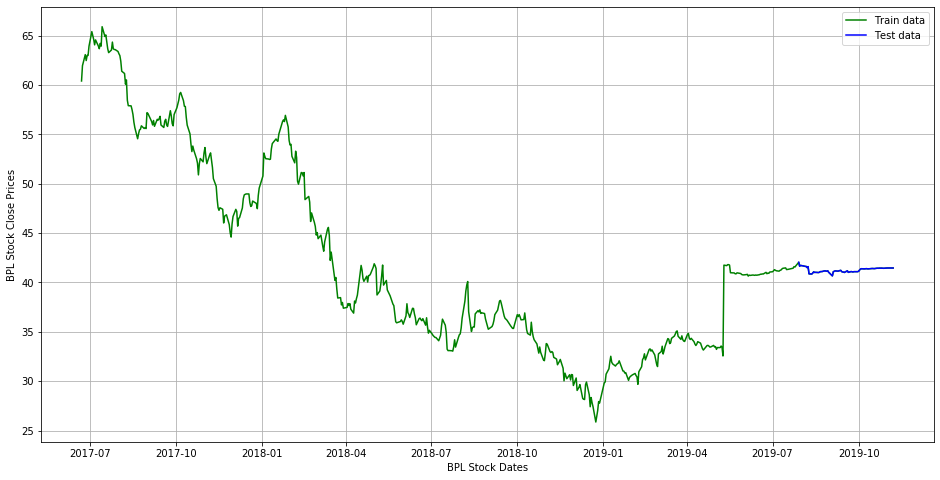

In [8]:
train_data, test_data = data[0:-73], data[-73:]
plt.figure(figsize=(16,8))
plt.grid(True)
plt.xlabel('BPL Stock Dates')
plt.ylabel('BPL Stock Close Prices')
plt.plot(data['close'].tail(600), 'green', label='Train data')
plt.plot(test_data['close'], 'blue', label='Test data')
plt.legend()

/Users/saurabhwadhawane/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



Lag: 36
MSE: 0.019780917550142635
MAE: 0.06986297830127419
RMSE: 0.1406446499165277


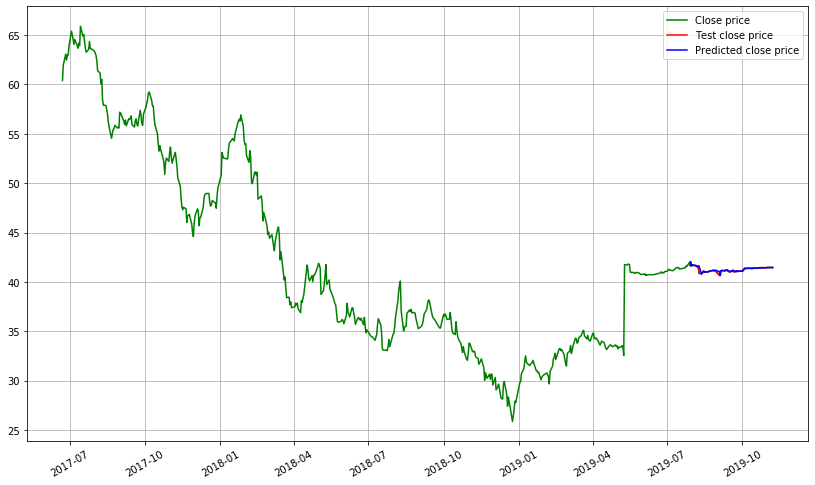

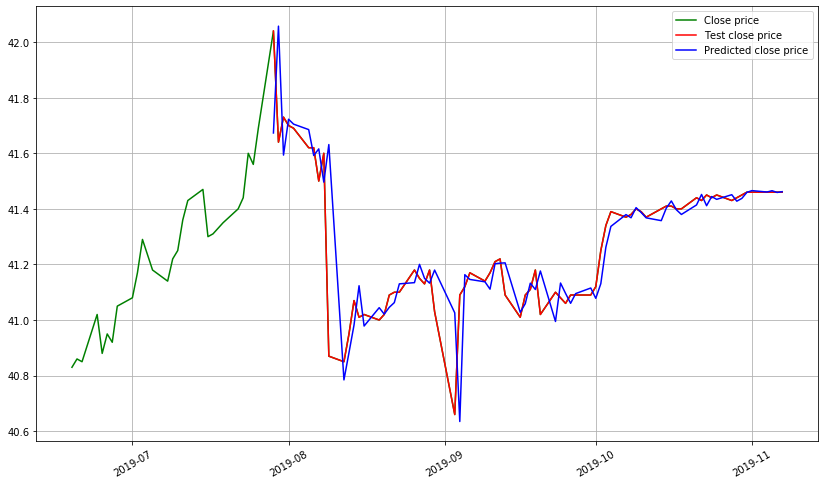

In [10]:
#Autoregression Model

train_ar = train_data['close']
test_ar = test_data['close']

model = AR(train_ar)# train autoregression
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train_ar[len(train_ar)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test_ar)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test_ar[t]
    predictions.append(yhat)
    history.append(obs)
 
plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['close'].tail(600), color='green', label='Close price')
plt.plot(test_data.index, test_data['close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

plt.figure(figsize=(14,8))
print('Lag: %s' % model_fit.k_ar)
plt.plot(data.index[-100:], data['close'].tail(100), color='green', label='Close price')
plt.plot(test_data.index, test_data['close'], color='red', label='Test close price')
plt.plot(test_data.index, predictions, color='blue', label='Predicted close price')
plt.xticks(rotation=30)
plt.grid(True)
plt.legend()

print('MSE: '+str(mean_squared_error(test_data['close'], predictions)))
print('MAE: '+str(mean_absolute_error(test_data['close'], predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['close'], predictions))))

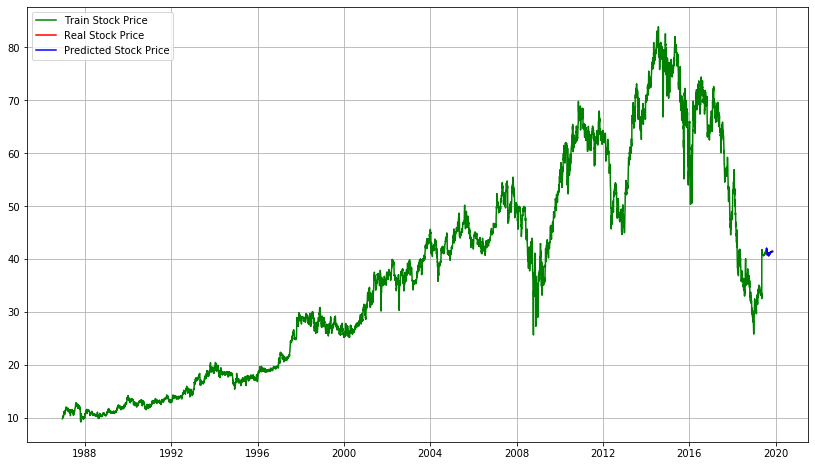

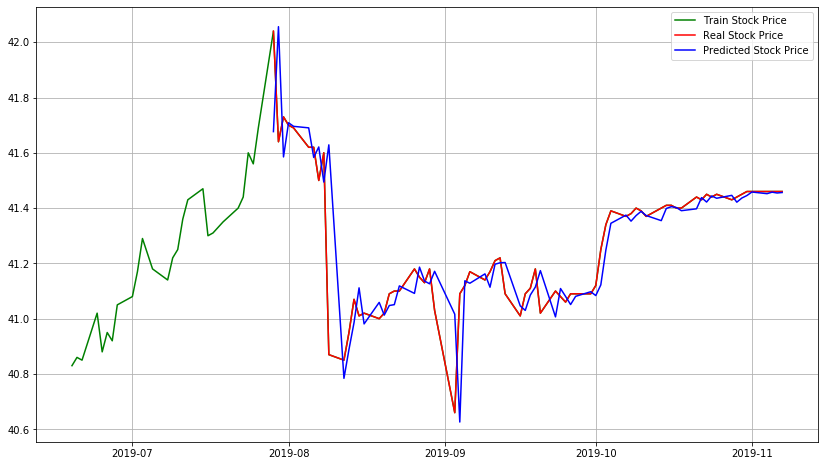

MSE: 0.0197721395245128
MAE: 0.0704695100245661
RMSE: 0.140613440056464


In [41]:
train_arma = train_data['close']
test_arma = test_data['close']

history = [x for x in train_arma]
y = test_arma
# make first prediction
predictions = list()
model = ARMA(history, order=(1,10))
model_fit = model.fit(disp=1)
yhat = model_fit.forecast()[0]
predictions.append(yhat)

history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARMA(history, order=(1,10))
    model_fit = model.fit(disp=1)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)

plt.figure(figsize=(14,8))
plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-100:], data['close'].tail(100), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

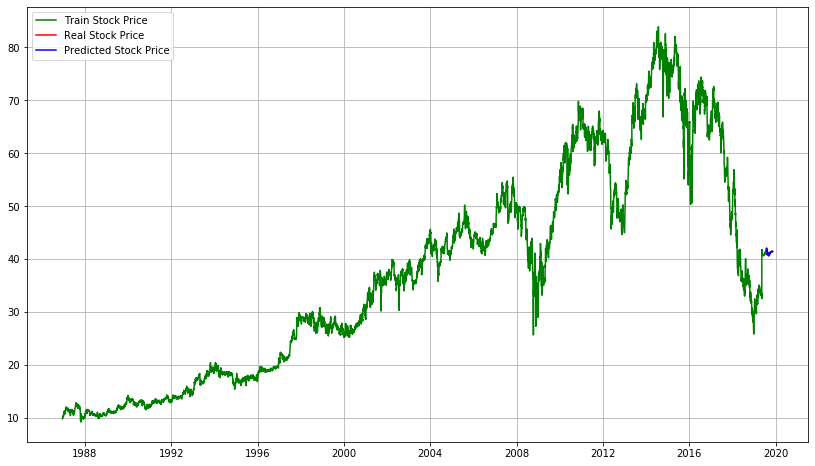

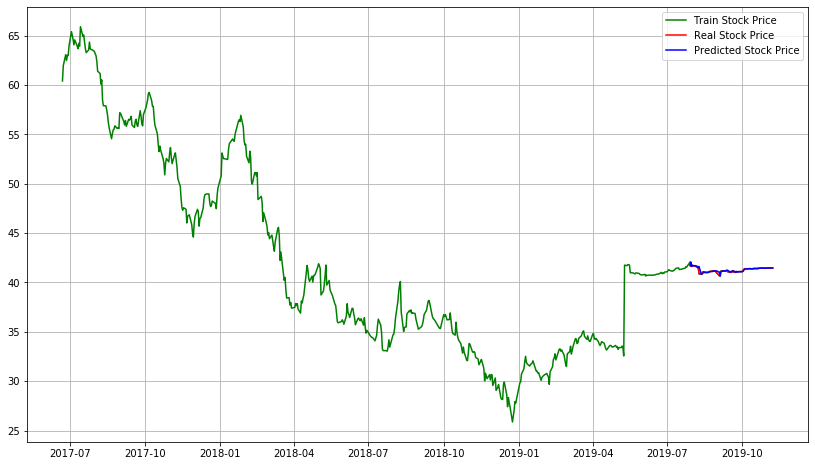

MSE: 0.019351480827192836
MAE: 0.06895469910817796
RMSE: 0.13910960005403233


In [43]:
train_arima = train_data['close']
test_arima = test_data['close']

history = [x for x in train_arima]
y = test_arima
# make first prediction
predictions = list()
model = ARIMA(history, order=(1,1,0))
model_fit = model.fit(disp=0)
yhat = model_fit.forecast()[0]
predictions.append(yhat)
history.append(y[0])
# rolling forecasts
for i in range(1, len(y)):
    # predict
    model = ARIMA(history, order=(1,1,1))
    model_fit = model.fit(disp=0)
    yhat = model_fit.forecast()[0]
    # invert transformed prediction
    predictions.append(yhat)
    # observation
    obs = y[i]
    history.append(obs)
    
plt.figure(figsize=(14,8))
plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, y, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predictions, color = 'blue', label = 'Predicted Stock Price')
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(y, predictions)))
print('MAE: '+str(mean_absolute_error(y, predictions)))
print('RMSE: '+str(sqrt(mean_squared_error(y, predictions))))

In [45]:
#Facebook_Prophet
# Drop the columns
ph_df_train = train_data.drop(['open', 'high', 'low','adjclose','volume','ticker'], axis=1)
ph_df_train['date'] = ph_df_train.index
ph_df_train.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)

prop = Prophet(changepoint_prior_scale=0.1)
prop.fit(ph_df_train)
# Create Future dates
future_prices = prop.make_future_dataframe(periods=73)

# Predict Prices
forecast = prop.predict(future_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


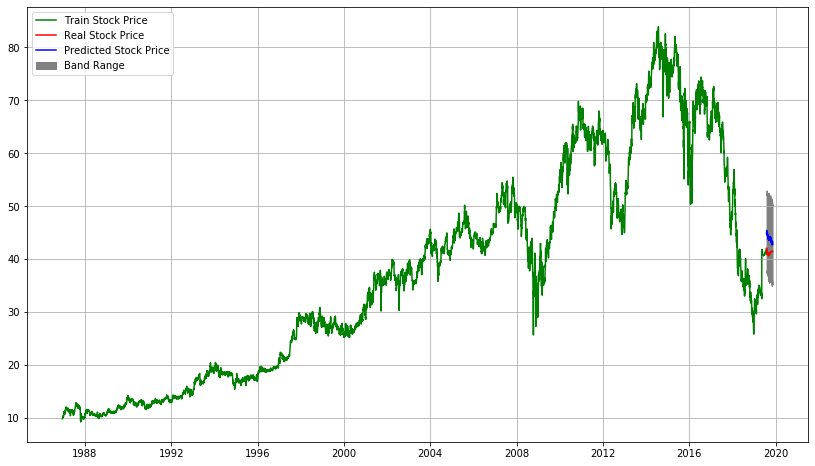

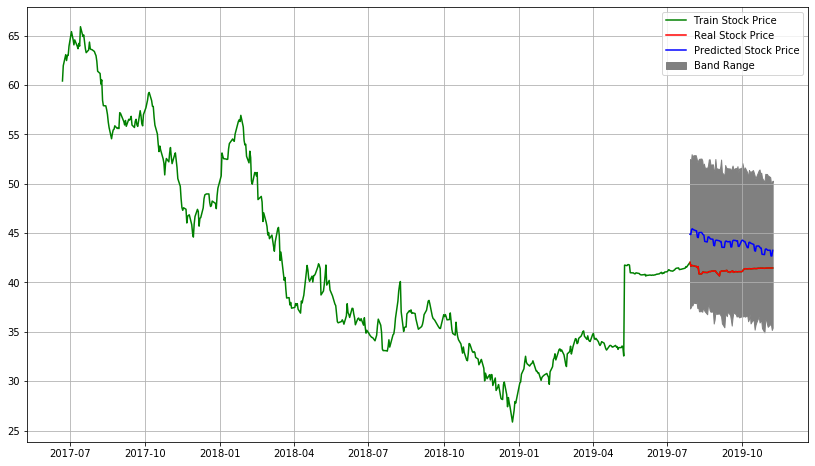

MSE: 8.212028557402475
MAE: 2.779012251655541
RMSE: 2.865663720223026


In [46]:
plt.figure(figsize=(14,8))
plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['close'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(14,8))
plt.plot(data.index[-600:], data['close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, test_data['close'], color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, forecast['yhat'][-73:], color = 'blue', label = 'Predicted Stock Price')
plt.fill_between(test_data.index, forecast['yhat_lower'][-73:], forecast['yhat_upper'][-73:], color='grey', label="Band Range")
plt.legend()
plt.grid(True)
plt.show()

print('MSE: '+str(mean_squared_error(test_data['close'], forecast['yhat'][-73:])))
print('MAE: '+str(mean_absolute_error(test_data['close'], forecast['yhat'][-73:])))
print('RMSE: '+str(sqrt(mean_squared_error(test_data['close'], forecast['yhat'][-73:]))))

In [64]:
#LSTM
train = train_data.iloc[:, 0:1].values # selecting close prices
# Feature Scaling
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train) 
# Train dataset
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) # we take 30 previous prices
    y_train.append(train_scaled[i, 0]) # and 60-th price as y value
X_train, y_train = np.array(X_train), np.array(y_train)
# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
from numpy.random import seed
seed(2019)

In [65]:
model = Sequential()

# Adding the first LSTM layer 
# Here return_sequences=True means whether to return the last output in the output sequence, or the full sequence.
# it basically tells us that there is another(or more) LSTM layer ahead in the network.
model.add(LSTM(units = 60, return_sequences = True, input_shape = (X_train.shape[1], 1)))
# Dropout regularisation for tackling overfitting
model.add(Dropout(0.2))

model.add(LSTM(units = 50))
model.add(Dropout(0.25))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
# RMSprop is a recommended optimizer as per keras documentation
# check out https://keras.io/optimizers/ for more details
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 300, batch_size = 16)

Epoch 1/300
8212/8212 [==============================] - 5s 553us/step - loss: 0.0067
Epoch 2/300
8212/8212 [==============================] - 4s 460us/step - loss: 0.0022
Epoch 3/300
8212/8212 [==============================] - 4s 462us/step - loss: 0.0017
Epoch 4/300
8212/8212 [==============================] - 4s 459us/step - loss: 0.0015
Epoch 5/300
8212/8212 [==============================] - 4s 464us/step - loss: 0.0012
Epoch 6/300
8212/8212 [==============================] - 4s 466us/step - loss: 0.0011
Epoch 7/300
8212/8212 [==============================] - 4s 466us/step - loss: 9.0333e-04
Epoch 8/300
8212/8212 [==============================] - 4s 461us/step - loss: 8.2259e-04
Epoch 9/300
8212/8212 [==============================] - 4s 451us/step - loss: 7.8737e-04
Epoch 10/300
8212/8212 [==============================] - 4s 467us/step - loss: 7.1001e-04
Epoch 11/300
8212/8212 [==============================] - 4s 466us/step - loss: 7.2500e-04
Epoch 12/300
8212/8212 [========

8212/8212 [==============================] - 4s 457us/step - loss: 5.3202e-04
Epoch 181/300
8212/8212 [==============================] - 4s 457us/step - loss: 5.3500e-04
Epoch 182/300
8212/8212 [==============================] - 4s 455us/step - loss: 5.5159e-04
Epoch 183/300
8212/8212 [==============================] - 4s 453us/step - loss: 5.3821e-04
Epoch 184/300
8212/8212 [==============================] - 4s 453us/step - loss: 5.1699e-04
Epoch 185/300
8212/8212 [==============================] - 4s 457us/step - loss: 5.3804e-04
Epoch 186/300
8212/8212 [==============================] - 4s 456us/step - loss: 5.2452e-04
Epoch 187/300
8212/8212 [==============================] - 4s 462us/step - loss: 5.3358e-04
Epoch 188/300
8212/8212 [==============================] - 4s 502us/step - loss: 5.3708e-04
Epoch 189/300
8212/8212 [==============================] - 4s 485us/step - loss: 5.4347e-04
Epoch 190/300
8212/8212 [==============================] - 4s 490us/step - loss: 5.4670e-04
Ep

In [66]:
# this will be used later while comparing and visualization
real_stock_price = test_data.iloc[:,0:1].values # taking close price
# combine original train and test data vertically
# as previous close Prices are not present in test dataset
# e.g. for predicting close price for first date in test data, we will need stock close prices on timesteps previous dates  
combine = pd.concat((train_data['close'], test_data['close']), axis = 0)
# our test inputs also contains stock close Prices of last timesteps dates (as described above)
test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1,1)
test_inputs = scaler.transform(test_inputs)
# same steps as we followed while processing training data
X_test = []
for i in range(timesteps, test_data.shape[0]+timesteps):
    X_test.append(test_inputs[i-timesteps:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
predicted_stock_price = model.predict(X_test)
# inverse_transform because prediction is done on scaled inputs
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

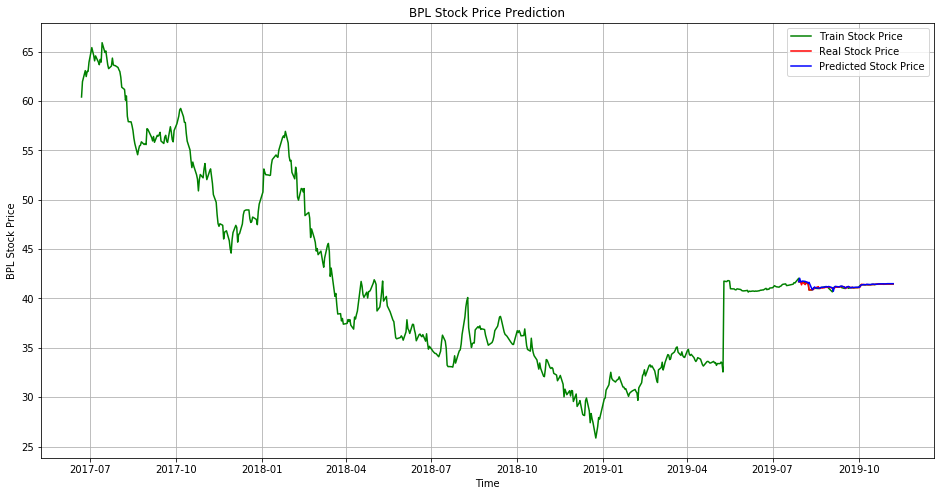

MSE: 0.015448692631875264
MAE: 0.06572085863922789
RMSE: 0.12429276982944448


In [77]:
plt.figure(figsize=(16,8))
plt.plot(data.index[-600:], data['close'].tail(600), color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('BPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BPL Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_IBM_NOV.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))

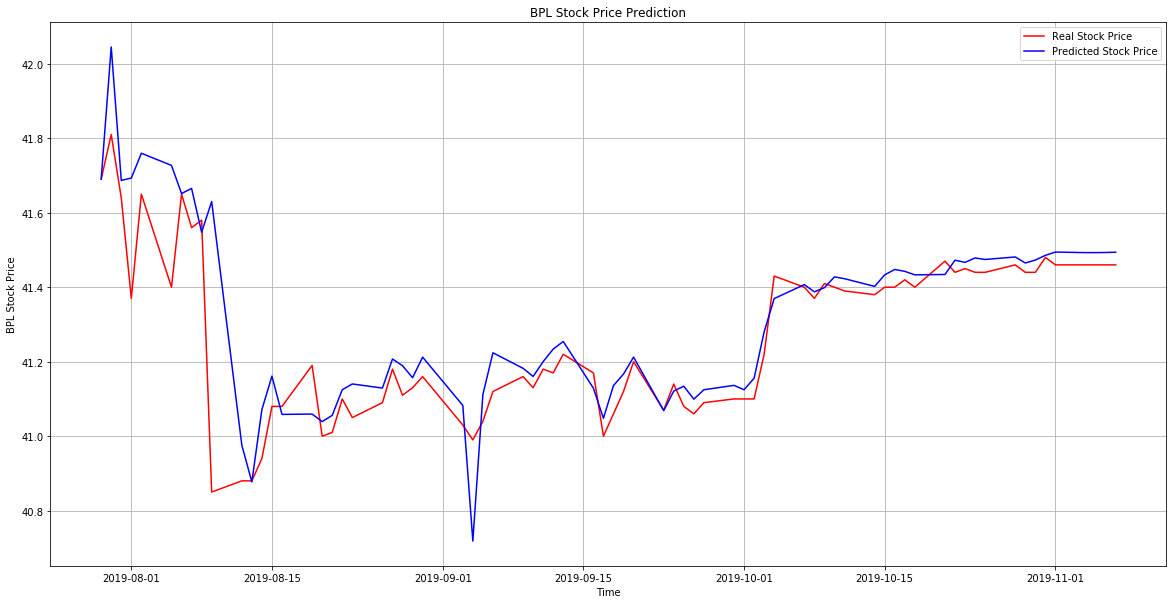

MSE: 0.015448692631875264
MAE: 0.06572085863922789
RMSE: 0.12429276982944448


In [78]:
plt.figure(figsize=(20,10))
#plt.plot(data.index, data['close'], color='green', label = 'Train Stock Price')
plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
plt.title('BPL Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('BPL Stock Price')
plt.legend()
plt.grid(True)
#plt.savefig('lstm_IBM_NOV.pdf')
plt.show()

mse = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse))
mae = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae))
rmse = sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse))